<span>
<b>Author:</b> Chenxiang Zhang <br/>
<b>Python version:</b>  3.x <br/>
</span>

## Predictive Analysis
...

In [146]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [183]:
df = pd.read_csv('../../data/profile/vendor_profile_log.csv', sep=',', index_col=0)
df.sort_values(by=['revenue_per_day'])

,unique_ram,revenue_per_unit,revenue_per_day,days
vendor_code,,,,
77,1.176091,2.064904,1.081800,2.863917
66,1.146128,2.092761,1.464854,2.352183
61,1.000000,2.002870,1.626776,2.401401
81,0.778151,2.177278,1.794943,1.913814
29,1.681241,2.166782,1.967852,2.864511
...,...,...,...,...
50,3.035029,2.201361,4.093288,2.864511
63,2.697229,2.306990,4.118632,2.818226
45,2.891537,2.303182,4.339174,2.864511


### Vendor Profile: Quantiles Approach
We profile each vendor discretizing each feature into 2-quantiles {0,1} and mapping the sum of features into a new column 'type'. The created column represent the vendor profile. Then we compare the best clustering algorithm's profiling with this approach

In [184]:
# discretize every feature using bi-quantiles
df_profile = pd.DataFrame()
for c in df.columns:
    df_profile[c] = pd.qcut(df[c], q=2, labels=[0,1])
df_profile

,unique_ram,revenue_per_unit,revenue_per_day,days
vendor_code,,,,
1,0,0,0,1
2,1,0,0,1
3,1,0,1,0
4,0,0,1,0
5,1,1,1,0
...,...,...,...,...
77,0,0,0,0
78,0,0,0,1
79,1,0,1,1


In [198]:
# compute vendor profile
# map the values: 0,1,2 -> small vendor
#                 3,4   -> big vendor
vendor_type = df_profile.sum(axis=1)
vendor_type = vendor_type.map({0:'small', 1:'small', 2:'small', 
                               3:'big', 4:'big'})

# dataset with vendor profile computed with quantiles
df_quant = df.copy()
df_quant['type'] = vendor_type
df_quant

# save the file
# df_quant.to_csv('../../data/profile/vendor_profile_quant.csv', sep=',')

In [199]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# normalize the data and reduce the dimension
scaler = StandardScaler()
X = scaler.fit_transform(df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_X = pd.DataFrame(X_pca, columns=['Component0', 'Component1'])
df_X.index = df.index

df_small = df_X[df_quant['type']=='small']
df_big = df_X[df_quant['type']=='big']

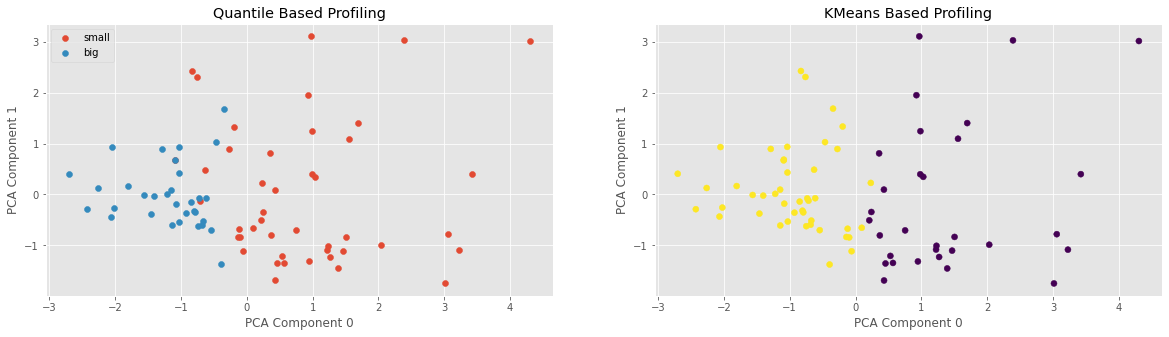

In [201]:
# comparison quantile based profiling approach and KMeans profiling in two dimension
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.scatter(df_small['Component0'], df_small['Component1'], label='small')
plt.scatter(df_big['Component0'], df_big['Component1'], label='big')
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('Quantile Based Profiling')
plt.legend()

plt.subplot2grid(fig_dims, (0, 1))
kmeans = KMeans(n_clusters=2, random_state=4)
kmeans.fit(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('KMeans Based Profiling')

plt.savefig('../../tex/imgs/predict_data_quantiles.pdf')

In [202]:
# quantitative measure of two clusters

# the data is scarse and irregular, thus even if the quant approach has
# a lower score we choose this for predictive tasks
from sklearn.metrics import silhouette_score
print('Silhouette Quant: \t', silhouette_score(X_pca, df_quant['type'].values))
print('Silhouette KMeans: \t', silhouette_score(X_pca, kmeans.labels_))

Silhouette Quant: 	 0.28631428597793357
Silhouette KMeans: 	 0.3927260284004955


### Data Splitting and Model Selection
Split the complete dataset into train set (70%) and test set (30%). The split is done in a stratified way to preserve the label's distribution. For model selection we decide to use the grid search to navigate through the space looking for a good set of hyperparameters and we use the cross-validation based on the train set's average result to evaluate the model's performance.
- Stratified K-fold: https://scikit-learn.org/stable/modules/cross_validation.html#stratification

In [296]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
import scipy.stats as stats

In [210]:
quant = df_quant.to_numpy()
X, y = quant[:, :-1], quant[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [217]:
len(y_train[y_train=='big'])/len(y_train)

0.41509433962264153

### Utility Functions
...

In [295]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [541]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:1]:
            print("Model rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_learning_curve(pipeline, X, y, cv=4, 
                        train_sizes=np.linspace(.1, 1.0, 5),
                        random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring='accuracy', n_jobs=-1,
                                                            random_state=random_state)

    train_score_mean = np.mean(train_scores, axis=1)
    train_score_std = np.std(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)
    test_score_std = np.std(test_scores, axis=1)

    plt.title(str(pipeline['estimator'].__class__.__name__) + ' Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')

    # clamp values in 0, 1
    train_up = train_score_mean + train_score_std
    train_up = [score if score < 1 else 1 for score in train_up]
    train_down = train_score_mean - train_score_std
#     train_down = [score if score > 0 else 0 for score in train_down]
    
    test_up = test_score_mean + test_score_std
    test_up = [score if score < 1 else 1 for score in test_up]
    test_down = test_score_mean - test_score_std
#     test_down = [score if score > 0 else 0 for score in test_down]
    
    # plot the learning curve
    plt.plot(train_sizes, train_score_mean, label='train score', marker='.')
    plt.fill_between(train_sizes, train_up, train_down, alpha=0.2)
    plt.plot(train_sizes, test_score_mean, label='cross-validation score', marker='.')
    plt.fill_between(train_sizes, test_up, test_down, alpha=0.2)

    plt.legend()


### Support Vector Classifier
...

In [278]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [363]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', SVC())])

hyperparams = {
    'estimator__C': stats.randint(1, 500),
    'estimator__kernel': ['rbf', 'linear', 'poly'],
    'estimator__degree': [3, 4, 5]
}

# uses default stratified KFold for classification
svc_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=100,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [364]:
report(svc_rand.cv_results_)

Model rank: 1
Mean validation score: 0.905 (std: 0.034)
Parameters: {'estimator__C': 105, 'estimator__degree': 3, 'estimator__kernel': 'rbf'}

Model rank: 2
Mean validation score: 0.887 (std: 0.036)
Parameters: {'estimator__C': 37, 'estimator__degree': 3, 'estimator__kernel': 'rbf'}



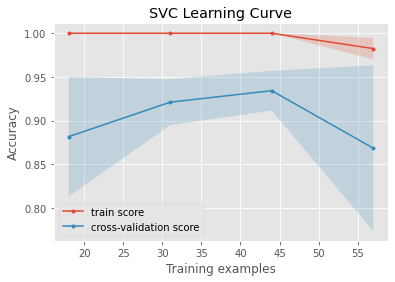

In [542]:
plot_learning_curve(svc_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_svm_learning_curve.pdf')

In [350]:
# evaluation on test set
y_pred = svc_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      1.00      1.00        10
       small       1.00      1.00      1.00        13

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



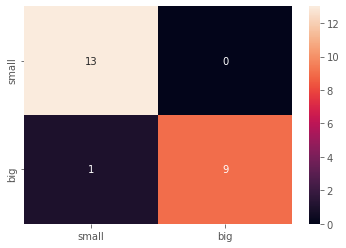

In [509]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_svc_confusion.pdf')

### Naive Bayes
...

In [311]:
from sklearn.naive_bayes import GaussianNB

In [317]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', GaussianNB())])

hyperparams = {}

nb_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=1,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [318]:
report(nb_rand.cv_results_)

Model rank: 1
Mean validation score: 0.848 (std: 0.056)
Parameters: {}



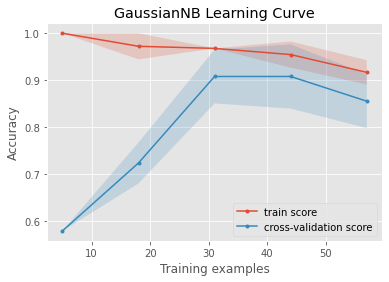

In [543]:
plot_learning_curve(nb_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_nb_learning_curve.pdf')

In [321]:
# evaluation on test set
y_pred = nb_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      1.00      1.00        10
       small       1.00      1.00      1.00        13

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



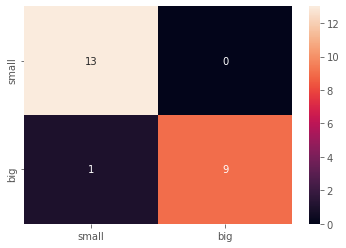

In [511]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_nb_confusion.pdf')

### K Nearest Neighbor
...

In [365]:
from sklearn.neighbors import KNeighborsClassifier

In [369]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', KNeighborsClassifier())])

hyperparams = {
    'estimator__n_neighbors': stats.randint(2, 20),
    'estimator__algorithm': ('ball_tree', 'kd_tree', 'brute')
}

knn_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=100,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [370]:
report(knn_rand.cv_results_)

Model rank: 1
Mean validation score: 0.867 (std: 0.065)
Parameters: {'estimator__algorithm': 'ball_tree', 'estimator__n_neighbors': 5}



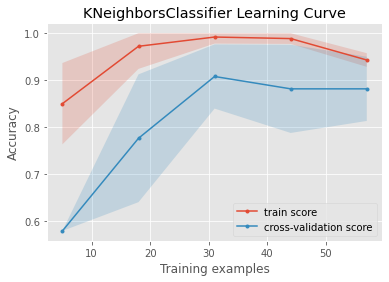

In [544]:
plot_learning_curve(knn_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_knn_learning_curve.pdf')

In [334]:
# evaluation on test set
y_pred = knn_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      0.80      0.89        10
       small       0.87      1.00      0.93        13

    accuracy                           0.91        23
   macro avg       0.93      0.90      0.91        23
weighted avg       0.92      0.91      0.91        23



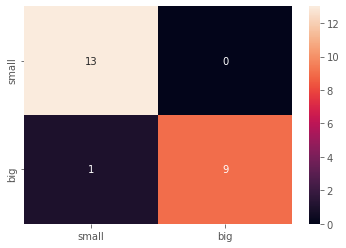

In [513]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_knn_confusion.pdf')

### Decision Tree
...

In [336]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [390]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', DecisionTreeClassifier())])

hyperparams = {
    'estimator__splitter': ('best', 'random'),
    'estimator__max_depth': stats.randint(1, 100),
    'estimator__max_features': ('auto', 'sqrt', 'log2'),
    'estimator__criterion': ('gini', 'entropy'),
    'estimator__random_state': ([5])
}

dt_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=400,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [391]:
report(dt_rand.cv_results_)

Model rank: 1
Mean validation score: 0.907 (std: 0.029)
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 91, 'estimator__max_features': 'sqrt', 'estimator__random_state': 5, 'estimator__splitter': 'best'}



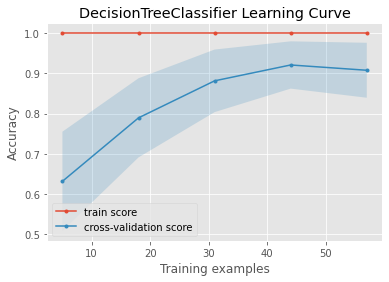

In [545]:
plot_learning_curve(dt_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_dt_learning_curve.pdf')

In [394]:
# evaluation on test set
y_pred = dt_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      0.80      0.89        10
       small       0.87      1.00      0.93        13

    accuracy                           0.91        23
   macro avg       0.93      0.90      0.91        23
weighted avg       0.92      0.91      0.91        23



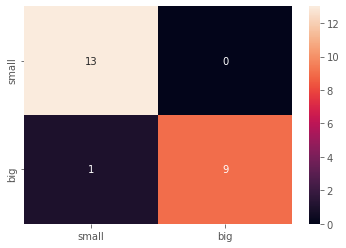

In [515]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_dt_confusion.pdf')

### Random Forest
...

In [547]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', RandomForestClassifier())])

hyperparams = {
    'estimator__n_estimators': stats.randint(1, 10),
    'estimator__max_depth': stats.randint(1, 100),
    'estimator__max_features': ('auto', 'sqrt', 'log2'),
    'estimator__criterion': ('gini', 'entropy')
}

rf_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=400,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


In [548]:
report(rf_rand.cv_results_)

Model rank: 1
Mean validation score: 0.962 (std: 0.038)
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 74, 'estimator__max_features': 'log2', 'estimator__n_estimators': 5}



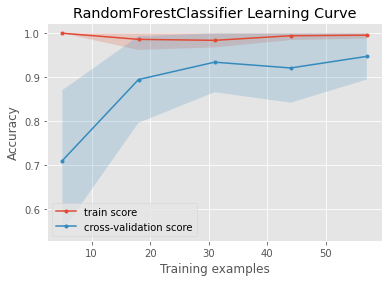

In [549]:
plot_learning_curve(rf_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_rf_learning_curve.pdf')

In [550]:
# evaluation on test set
y_pred = rf_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      0.90      0.95        10
       small       0.93      1.00      0.96        13

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23



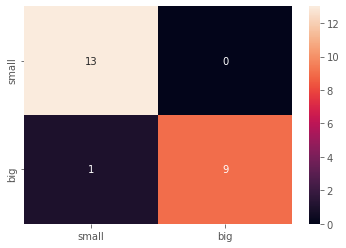

In [551]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_rf_confusion.pdf')

### Neural Network
...

In [412]:
from sklearn.neural_network import MLPClassifier

In [418]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', MLPClassifier())])

hyperparams = {
    'estimator__hidden_layer_sizes': stats.randint(1, 50),
    'estimator__activation': ('logistic', 'tanh', 'relu'),
    'estimator__solver': ('sgd', 'adam'),
    'estimator__learning_rate_init': stats.uniform(0, 0.01),
    'estimator__alpha': stats.uniform(),
    'estimator__max_iter': stats.randint(100, 300)
}

nn_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=400,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


In [419]:
report(nn_rand.cv_results_)

Model rank: 1
Mean validation score: 0.905 (std: 0.084)
Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.4851866271781681, 'estimator__hidden_layer_sizes': 32, 'estimator__learning_rate_init': 0.00933784203035661, 'estimator__max_iter': 291, 'estimator__solver': 'adam'}

Model rank: 3
Mean validation score: 0.904 (std: 0.100)
Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1771579641129437, 'estimator__hidden_layer_sizes': 30, 'estimator__learning_rate_init': 0.008722040557788536, 'estimator__max_iter': 242, 'estimator__solver': 'sgd'}



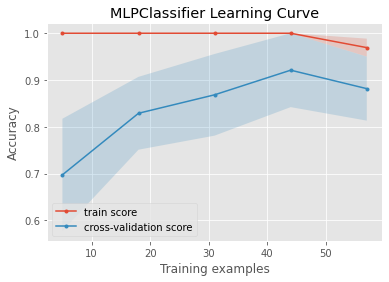

In [552]:
plot_learning_curve(nn_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_nn_learning_curve.pdf')

In [421]:
# evaluation on test set
y_pred = nn_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      0.90      0.95        10
       small       0.93      1.00      0.96        13

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23



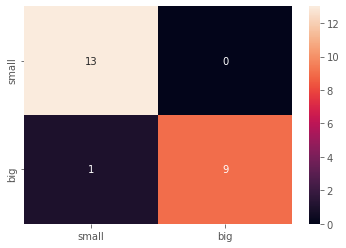

In [519]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_nn_confusion.pdf')

### Plot All Classifiers Stats
...

In [503]:
# training data X_pca, y
y = df_quant['type'].map({'small':0, 'big':1}).values

# create a mesh to plot in
h = 0.2
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

classifiers = [
    svc_rand.best_estimator_,
    nb_rand.best_estimator_,
    knn_rand.best_estimator_,
    dt_rand.best_estimator_,
    rf_rand.best_estimator_,
    nn_rand.best_estimator_
]

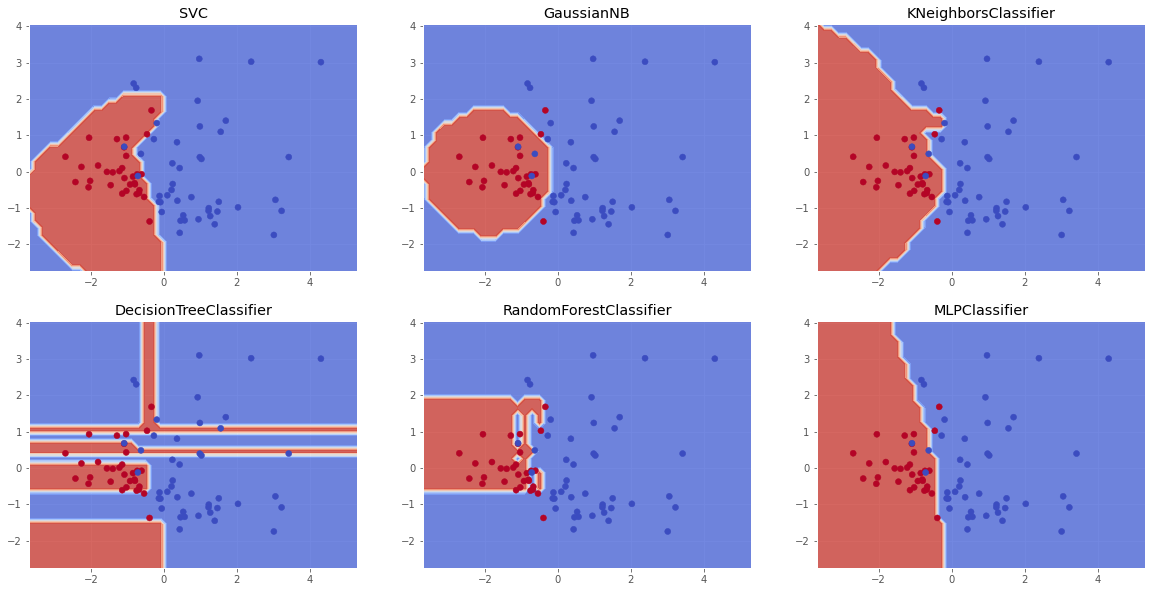

In [553]:
# plot the decision boundary of all the classifiers
fig = plt.figure(figsize=(20, 10)) 
for i, clf in enumerate(classifiers):
    # we will assign a color to each point in the mesh.
    plt.subplot(2, 3, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    clf.fit(X_pca, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # plot the training points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(str(clf['estimator'].__class__.__name__))

In [522]:
plt.savefig('../../tex/imgs/predict_compare_all.pdf')

<Figure size 432x288 with 0 Axes>